In [108]:
import time

import cv2
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from itertools import groupby
from skimage import io
from tqdm import tqdm

import pycocotools.mask as mask_util

In [109]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()

    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths

    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T

In [110]:
def binary_mask_to_rle(binary_mask):
    """
    Checkout: https://cocodataset.org/#format-results
    :param mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask

    This function returns the following dictionary:
    {
        "counts": encoded mask suggested by the official COCO dataset webpage.
        "size": the size of the input mask/image
    }
    """
    # Create dictionary for the segmentation key in the COCO dataset
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    # We need to convert it to a Fortran array
    binary_mask_fortran = np.asfortranarray(binary_mask)
    # Encode the mask as specified by the official COCO format
    encoded_mask = mask_util.encode(binary_mask_fortran)
    # We must decode the byte encoded string or otherwise we cannot save it as a JSON file
    rle["counts"] = encoded_mask["counts"].decode()
    return rle

In [111]:
def create_coco_format_json(data_frame, classes, filepaths):
    """
    This function creates a COCO dataset.
    :param data_frame: pandas dataframe with an "id" column.
    :param classes: list of strings where each string is a class.
    :param filepaths: a list of strings containing all images paths
    :return dataset_coco_format: COCO dataset (JSON).
    """
    images = []
    annotations = []
    categories = []
    count = 0

    # Creates a categories list, i.e: [{'id': 0, 'name': 'a'}, {'id': 1, 'name': 'b'}, {'id': 2, 'name': 'c'}]
    for idx, class_ in enumerate(classes):
        categories.append(
            {
                "id": class_,
                "name": f'class_{class_}'
            }
        )

    # Iterate over image filepaths
    for filepath in tqdm(filepaths):
        # Get the image id, e.g: "10044"
        #print(filepath)
        file_id = filepath.split("/")[-1]
        #print(file_id)
        # Get the image height, e.g: 360 (px)
        height = 256
        # Get the image width, e.g: 310 (px)
        width = 256
        # One image has many annotations associated to it (1 for each class), get a list with the indices.
        ids = data_frame.index[data_frame['ImageId'] == file_id].tolist()
        #print(ids)
        # Get filename
        file_name = filepath.split("/")[-1]


        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id": file_id,
                    "width": width,
                    "height": height,
                    "file_name": file_name
                }
            )
            for idx in ids:
                # Convert the RLE string into a numpy array binary mask
                mk = rle_decode(data_frame.iloc[idx]['EncodedPixels'], (width, height))
                """
                Contours can be explained simply as a curve joining all the continuous points (along the boundary),
                having same color or intensity. The function retrieves contours from the binary image using the
                algorithm specified in the function. One RLE segmentation for a single class may have disconnected
                shapes, like "spots". We will iterate over these "spots" thus creating a new image for each spot.
                This image will be temporary, it will help us create annotations for each of these "spots".
                """
                contours, hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

                for id_, contour in enumerate(contours):
                    # Image with 3 channels where H and W remain the same.
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    # This function takes the image and fills the contour inside it.
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc = binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation': enc,
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':file_id,
                        'category_id':int(data_frame.iloc[idx]['ClassId']),
                        'iscrowd':0,
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1


    # Create the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }

    return dataset_coco_format


def sep():
    print("-"*100)

In [112]:
height = 256
width = 256
data_path = '/home/eas/Enol/pycharm_projects/clipseg/third_party/Severstal/train_subimages'

In [113]:
df = pd.read_csv('~/Enol/pycharm_projects/clipseg/third_party/Severstal/subimages.csv')
#Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

In [114]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
df_train = df.iloc[:split_index]
df_val = df.iloc[split_index:]
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [115]:
mk = rle_decode(df.iloc[0]['EncodedPixels'], (256, 256))
contours, hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

In [116]:
classes = sorted(df["ClassId"].unique().tolist())

In [117]:
filepaths = list()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".jpg")]

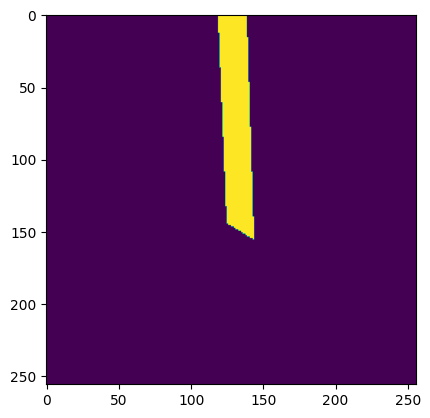

In [118]:
rle = df.loc[1, 'EncodedPixels']
#print(rle)
plt.imshow(rle_decode(rle, (256, 256)))

In [119]:
g_json_train = create_coco_format_json(df_train, classes, filepaths)
g_json_val = create_coco_format_json(df_val, classes, filepaths)

100%|██████████| 87976/87976 [00:40<00:00, 2162.68it/s]


In [123]:
with open('/home/eas/Enol/pycharm_projects/clipseg/third_party/Severstal/annotations_COCO_train.json', 'w', encoding='utf-8') as f:
    json.dump(g_json_train, f, indent=4)

In [124]:
with open('/home/eas/Enol/pycharm_projects/clipseg/third_party/Severstal/annotations_COCO_val.json', 'w', encoding='utf-8') as f:
    json.dump(g_json_val, f, indent=4)

In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [2]:
coco = COCO("/home/eas/Enol/pycharm_projects/clipseg/third_party/Severstal/annotations_COCO_val.json")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [3]:
imgIds = coco.getImgIds()

In [4]:
z=coco.getImgIds()[0]

In [12]:
coco.loadAnns([1:2])

SyntaxError: invalid syntax (3077817671.py, line 1)

In [6]:
dataDir=Path('/home/eas/Enol/pycharm_projects/clipseg/third_party/Severstal/train_subimages')

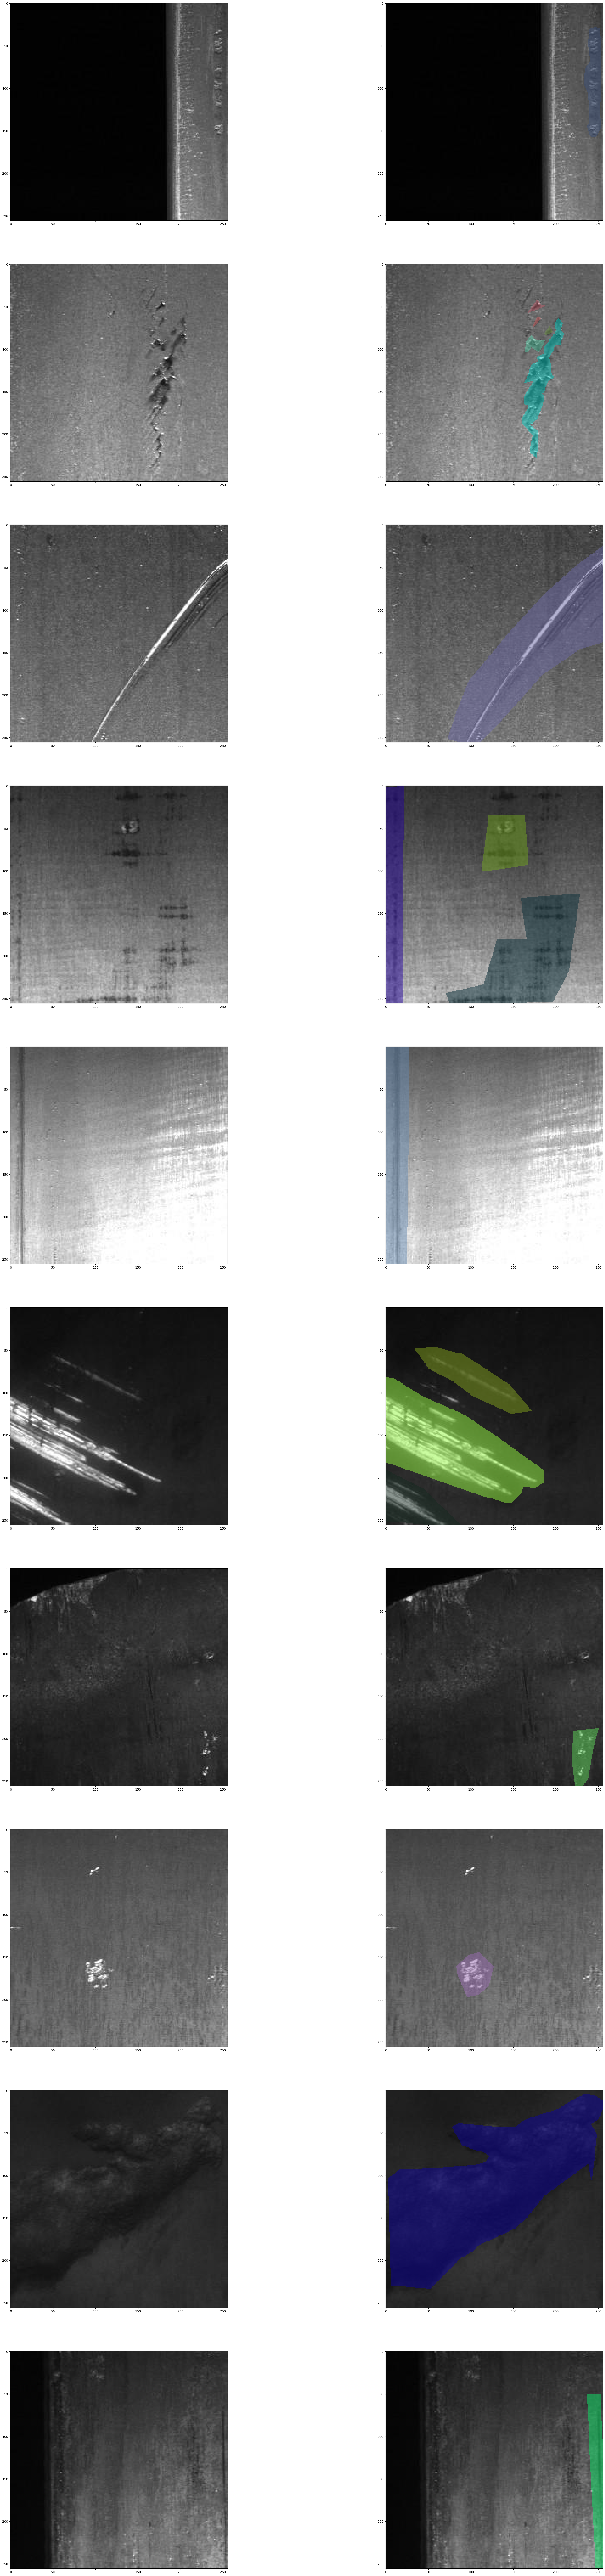

In [7]:
imgs = coco.loadImgs(imgIds[-10:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=False)